# CS5489 Course Project: BirdCLEF 2023 ([Kaggle](https://www.kaggle.com/competitions/birdclef-2023))

Team and contribution:
* LIU Yuhao,
* YANG Shiyuan, 57580180

## Quick overview

#### **Various methods we attempted**
* CNN Models:
    * EfficientNet
    * MobileNetv3
    * ConvNext
* Transformer Model:
* Machine Learning Models:
    * SVM
    * Logistic regression
    * ...
We conduct cross validation to proved that **EfficientNet** achieves the best performance with the acc of xxx, thus is adopted in final submission.

#### **Various feature representations used**
* Mel spectrum with 128 bins
* MFCC with 20 coefficients
* Chroma feature with 12 keys
We conduct cross validation to proved that **Mel spectrum** is the best feature thus is adopted in final submission.

#### **Short conclusion**
...


## Data Feature representations
We tried 3 different types of feature representations, all of them can be regarded as dimension-reduced representations compared with original audio, listed as follows by descending complexity order. 

#### **Mel-spectrum**
The Mel spectrogram is derived from the Short-Time Fourier Transform (STFT). In the Mel spectrogram, the frequency axis is converted to the Mel scale, which more closely reflects how humans perceive pitch differences. The Mel scale places more emphasis on lower frequencies while compressing higher frequencies. To compute the Mel spectrogram:
* Audio signal is loaded with the sampling rate of 32kHz, which is required by kaggle official.
* The audio signal is divided into short, overlapping frames. Each frame is windowed with the size of 2048 and transformed using the Fourier Transform to obtain its frequency content. The stride between each window is 512 (aka, hop_length).
* These frequency components are then logarithmically mapped onto the Mel scale with 128 bins and converted into a log power spectrum.
* Therefore, the temporal length of a mel spectrum is sampling_rate(Hz) * audio_time (s) / hop_length.

#### **MFCC**
MFCCs are a dimensionality-reduced version of the Mel-spectrogram.  To get the MFCC:
*  the Discrete Cosine Transform (DCT) is applied to each 128-dim log-Mel bin vector.  We use 20-dimension DCT as done in assignment 2, so the 128-dim vector is convereted to 20-dim in each time step. 

The resulting MFCCs are a compact representation of the spectral envelope, capturing timbral and phonetic characteristics of audio signals. Typically, only the first few coefficients (e.g., the first 13) are retained, as they contain the most relevant information.


#### **Chroma features**
Chroma features are a representation of audio that captures the tonal content of a music signal. Chroma features provide a compact representation of the energy distribution across 12 pitch classes (C, C#, D, D#, E, F, F#, G, G#, A, A#, and B) in a given audio signal. As can be seen, it's frequency is further reduced to 12 dim, so chroma map is a 12*T matrix, where T is the temporal length. Chroma features are derived from the underlying harmonic content of a piece of sound, and they are often used in music-related tasks such as: music genre classification, chord recognition, music similarity and recommendation, etc.

#### **Features visualization**
Here is a sample visualization, figures from left from right show the audio wave, Mel-spectrum, MFCC, and Chroma features of a sample audio:

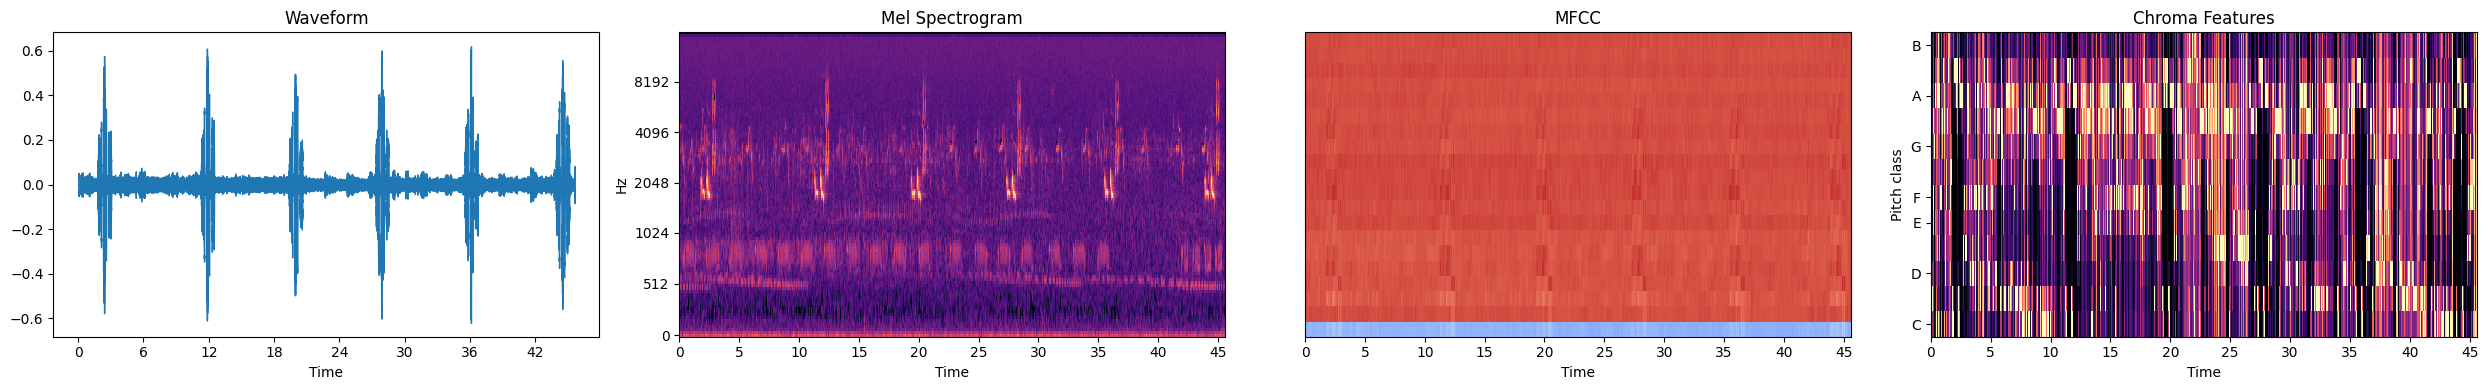

In [24]:
import librosa

######################### Generation ############################
# Audio
sr = 32000
sample_audio = "/home/yangshiyuan/Projects/birdclef-2023/train_audio/abethr1/XC128013.ogg"
x, sr = librosa.load(sample_audio, sr=sr)
# Mel-spectrum
mel = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmin=0, fmax=sr//2)
mel = librosa.power_to_db(mel, ref=np.max)
# MFCC
mfcc = librosa.feature.mfcc(S=mel, n_mfcc=20)
# Chroma
chroma_stft = librosa.feature.chroma_stft(y=x, sr=sr, n_chroma=12, n_fft=4096)

######################### Visualization ############################
# Show Audio
fig, axes = plt.subplots(1, 4, figsize=(25, 4))
axes = axes.flatten()
axes[0].set_title('Waveform')
librosa.display.waveshow(x, sr=sr, ax=axes[0])
# show Mel
axes[1].set_title('Mel Spectrogram')
librosa.display.specshow(mel, sr=sr, y_axis='mel', x_axis='time', ax=axes[1])
# show MFCC
axes[2].set_title('MFCC')
librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=axes[2])
# show Chroma
axes[3].set_title('Chroma Features')
librosa.display.specshow(chroma_stft, sr=sr, x_axis='time', y_axis='chroma', ax=axes[3])
plt.tight_layout()
plt.show()


## Method 1: Deep Learning with CNN Models

### Motivation and justification
In this task, we use several CNN models to process the frequency domain features of the given audio. Specifically, we use Mel-spectrogram. Although CNNs are mainly used for computer vision tasks, they are also highly suitable for Mel-spectrogram classification tasks for several reasons: 

* Mel-spectrograms are time-frequency representations of audio signals and are visually similar to images, this allows the CNN's classification ability to be easily extended to grid-like data.
* Automatic hierarchical feature learning: CNNs are good at capturing both local and global audio patterns. In the lower layers of the network, CNNs capture local patterns such as edges and frequency bands, while higher layers capture more abstract and global features, such as shapes and harmonic structures. This hierarchical feature extraction is especially effective for Mel-spectrogram classification, where both local and global patterns contribute to meaningful representations of audio.
* Translation Invariance: CNNs inherently exhibit translation invariance due to the shared weights in the convolutional layers. This means that a pattern learned in one region of the Mel-spectrogram can be recognized in other regions. This is highly useful for audio classification tasks because meaningful patterns may occur at different time steps in the Mel-spectrogram.
* End-to-End Training: feature extraction and classification are integrated into a single training process, eliminating the need for manual feature engineering.
* Better performance: we show later that CNN's performance is much better than traditional methods, e.g., Logistic regression and SVM.
For these reasons, CNNs have become a popular and effective choice for classifying Mel-spectrograms and other time-frequency representations of audio signals.



### Training Data Preparation (use Mel as an example)
Since we are using Mel spectrum as data format, converting audio to Mel can be time-consuming. Therefore, instead of on-the-fly processing, we opt to perform the conversion of audio to Mel spectrograms as a preprocessing step, completed offline prior to training. The processed data is stored as pickle file in local disk. 

Here are some information about our conversion: 
* Mel bins = 128, this is enough for most audio tasks.
* Sampling rate (SR): 32kHz, this is required by Kaggle official.
* Frequency upper limit: 16kHz, According to Nyquist's law, highest recognizable sound frequency is half of the sampling frequency
* Convert power to dB: the logarithmic scale of the Mel-spectrogram energy is more consistent with human ear perception

The pre-processed data consists of the following main fields which are used in our experiment:
* primary_label: the unique bird_name label.
* primary_label_idx: the unique bird_index label.
* mel: the converted mel spectrum, in numpy.array format.

**Code Implementation:**

Here is the code for generating the mel-spectrum from the given training audios (MFCC and chroma features can be generated in the same way).

In [ ]:
import pandas as pd
from collections import OrderedDict
import librosa,pickle
import  numpy as np
from tqdm import tqdm

# read train_metadata.csv
csv_data = pd.read_csv('train_metadata.csv')
sr = 32000

# convert csv to dict
data_dict=OrderedDict()
for col in csv_data.columns:
    data_dict[col]=csv_data[col].tolist()

# add key "mel" for storing mel
data_dict['mel'] = [0] * len(data_dict['primary_label'])

# convert audio to mel (THIS COSTS ~1 HOUR)
for idx, ogg_path in tqdm(enumerate(data_dict['filename'])):
    x, sr = librosa.load(f"train_audio/{ogg_path}", sr=sr)
    m = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmin=0, fmax=sr//2)
    m = librosa.power_to_db(m).astype(np.float32)
    data_dict['mel'][idx] = m

# assign number_id to each bird, stored in a dict name_label_2_int_label, i.e., name_label_2_int_label['bird_name'] = id
bird_names, _ = np.unique(data_dict['primary_label'], return_counts=True)
name_label_2_int_label = {}
for idx, k in enumerate(bird_names):
    name_label_2_int_label[k] = idx

# add key "primary_label_idx" for saving primary_label in num_id format
primary_label_idx=[0]*len(data_dict['primary_label'])
for i, tmp in enumerate(data_dict['primary_label']):
    primary_label_idx[i] = name_label_2_int_label[tmp]

# add key "secondary_label_idx" for saving primary_label in num_id format
import ast
secondary_label_idx=[0]*len(data_dict['primary_label'])
for i, tmp in enumerate(data_dict['secondary_labels']):
    if tmp == '[]':
        secondary_label_idx[i] = []
    else:
        tmp_label_list = ast.literal_eval(tmp)
        secondary_label_idx[i] = [name_label_2_int_label[p] for p in tmp_label_list]

# save our data dict into pickle file (~22GB)
with open("train_mel(dB,sr=32k,bin=128).pickle3", 'wb') as file:
    pickle.dump(data_dict, file)

### Training (with cross-validation for model selection)
This section presents our training details 

#### Cross-validation for feature selection
...

#### Cross-validation for model selection
To choose the best model, we conduct 5-fold cross-validation 
We provide our full training code here, we attempted three different CNN models:
* 1, params
* 2, params
* 3, params

#### Rare classes handling 
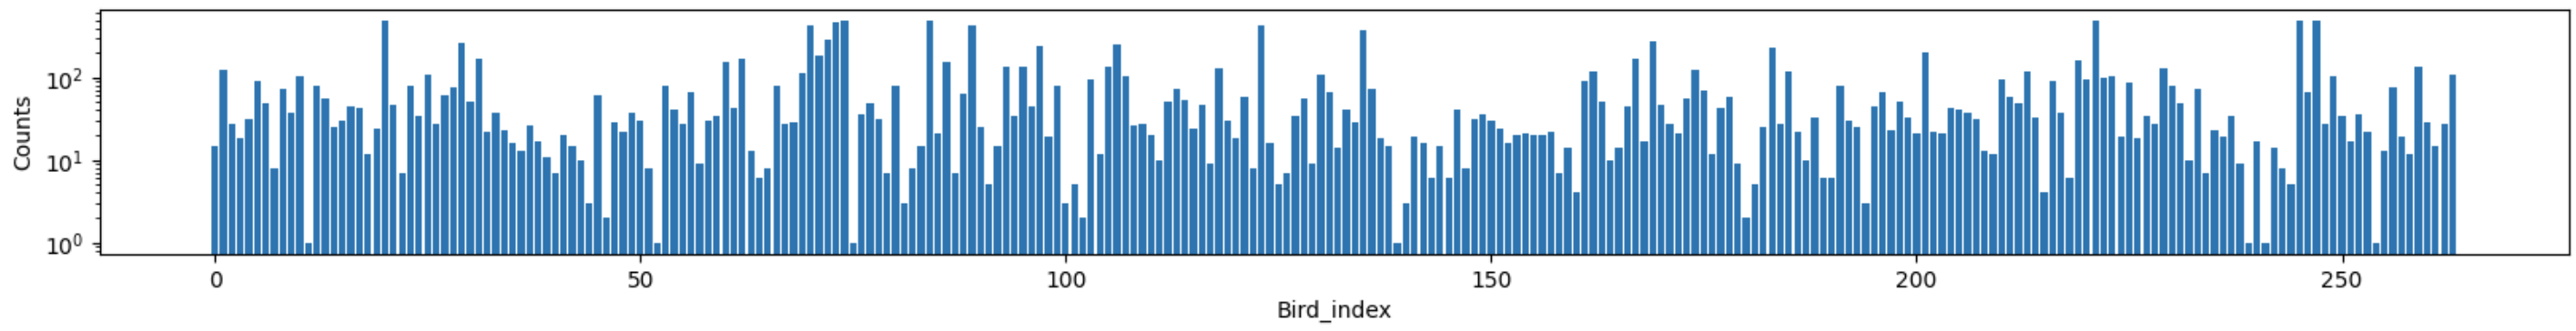

In practice, when splitting the dataset into training and validation sets, we found that for some relatively rare categories (e.g., 'afpkin1', 'brtcha1', 'crefra2 ...), due to their limited number of samples, there exits the possibility that some of them may only appear in the validation set but are missing in training set. Such an imbalance would result in the model being unable to learn features from these samples. To address this issue, we conducted an explicit inspection of the training and validation sets after splitting. We identified samples that were exclusively present in the validation set and incorporated them into the training set to ensure that the model could learn their features as much as possible.

#### Data padding & Clipping
Since the official test rule requires to predict each class's probability over 5-second audio clip, to make the model better adapt to this setting,  we also need to make each training sample 5-second long. Since $5s*32000Hz/512 = 313$, so the mel-spectrum should be in the width of 313.

* If mel-spectrum's length is larger than 313, we randomly crop a 313-wide subsection.
* If mel-spectrum's length is less than 313, we repeat the sample until it reaches 313.

As a result, each mel-spectrum image is in size of 128(bins)x313. Similarly, each MFCC image is in size of 20(bins)x313, each chroma map is in size of 12(keys)x303

#### Data normalization
During the training process,  we apply the normalization on data as follows:
$$ X' = \frac{X-mean(X)}{std(X)}$$
$$ X'' = \frac{X'-min(X')}{max(X')-min(X')}$$
This helps to make the data in consistent scale, facilitate faster converge and improve generalization ability of the network


#### Pipeline overview
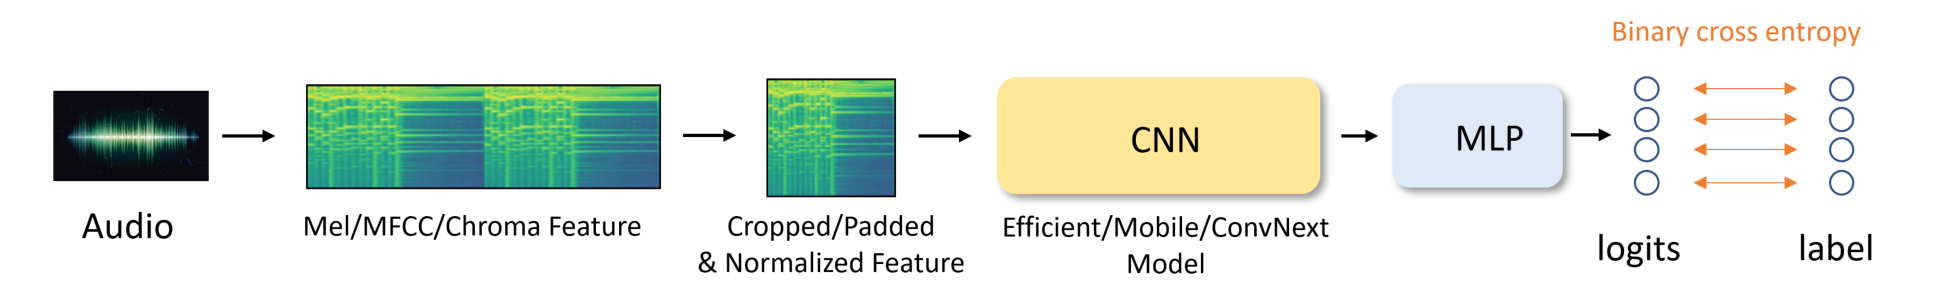

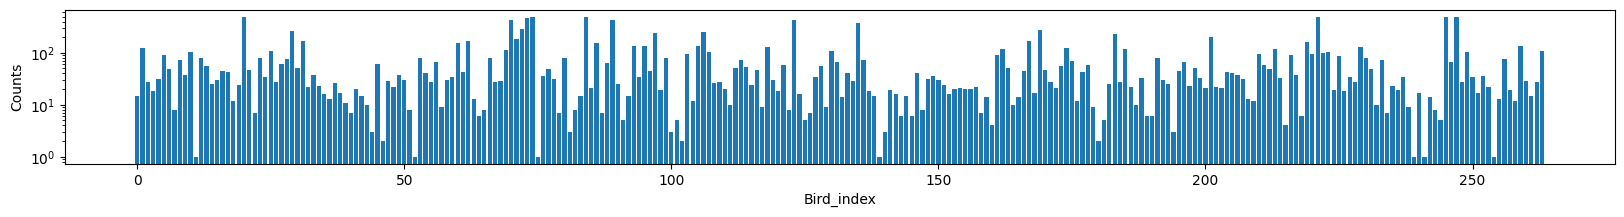

In [7]:
import pandas as pd
from collections import OrderedDict
import librosa,pickle
import  numpy as np
from tqdm import tqdm
# read train_metadata.csv
csv_data = pd.read_csv('train_metadata.csv')
sr = 32000
# convert csv to dict
data_dict=OrderedDict()
for col in csv_data.columns:
    data_dict[col]=csv_data[col].tolist()
    
bird_names, c = np.unique(data_dict['primary_label'], return_counts=True)
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,2))
plt.bar(list(range(len(c))), c)
# 设置X轴刻度标签的角度（例如45度倾斜）
# plt.xticks(rotation=45)
# 设置X轴和Y轴的标签
plt.yscale('log')
plt.xlabel('Bird_index')
plt.ylabel('Counts')
# 显示图形
plt.show()

# Tradional

# Conclusu and Dics